In [ ]:
!pip install catboost yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import shap

# Proyecto 1: Movistar

**Movistar está preocupada por el aterrizaje de Netflix y por la oferta de Vodafone. Teme que algunos de sus clientes que tienen contratado MovistarPlus se vean atraídos por la nueva oferta de Vodafone. Os plantea la realización del diseño de una campaña de incentivos para mantener el mayor número de clientes en su empresa. En concreto os piden:**

**1. Análisis de perfiles de posibles desertores. Os piden que determinéis un perfil del posible desertor. Y también un perfil para aquel que no lo sea. La empresa os proporciona un dataset con un histórico de clientes que han dejado la empresa y los que no. A partir de él tenéis que identificar el perfil o perfiles de los que han dejado la empresa para prever los que tienen una alta probabilidad de solicitar portabilidades a Vodafone. Los perfiles tienen que identificar los atributos relevantes y los valores para dichos atributos.**

In [ ]:
file_id = '1PceG_WINLWGZz6Z41Ryqkee_zl_krD1P'
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'

df = pd.read_csv(csv_url)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Primero, veremos algunas estadísticas generales de nuestro dataset

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Dimensiones del dataset: {df.shape}")

print(f"\nNulos en el dataset: {df.isna().sum().sum()}")
print("\nInformación general:")
display(df.info())
df['TotalCharges'] = df['TotalCharges'].fillna(0)

Dimensiones del dataset: (7043, 21)

Nulos en el dataset: 11

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contra

None

Las entradas sin datos en TotalCharges tienen tenure 0, es decir 0 meses de permanencia. Esto son clientes que acaban de registrarse por lo que factura total es 0

In [ ]:
print("\nDistribución de clientes por deserción:")
churn_distribution = pd.concat([df['Churn'].value_counts(),
                                df['Churn'].value_counts(normalize=True).mul(100).round(2).astype(str)],
                                axis=1, keys=['Recuento', 'Porcentaje'])

display(churn_distribution)


Distribución de clientes por deserción:


,Recuento,Porcentaje
Churn,,
No,5174,73.46
Yes,1869,26.54


Aproximadamente un 25% de los clientes se cambian de compañía. A continuación, haremos un EDA de los datos para hacernos una idea *grosso modo* de que variables pueden ser las más decisivas para los clientes a la hora de permanecer en nuestra compañía o abandonarnos.

### Visualización inicial

Para hacer una análisis exploratorio sólido, dividiremos las columnas en tres grupos: demográficas (que referencian al cliente como persona), de servicio (que referencian a los servicios de los que el cliente es beneficiario). A su vez, para hacer representaciones adecuadas de los datos debemos discernir entre variables categóricas y numéricas. Primero, veremos las variables categóricas:

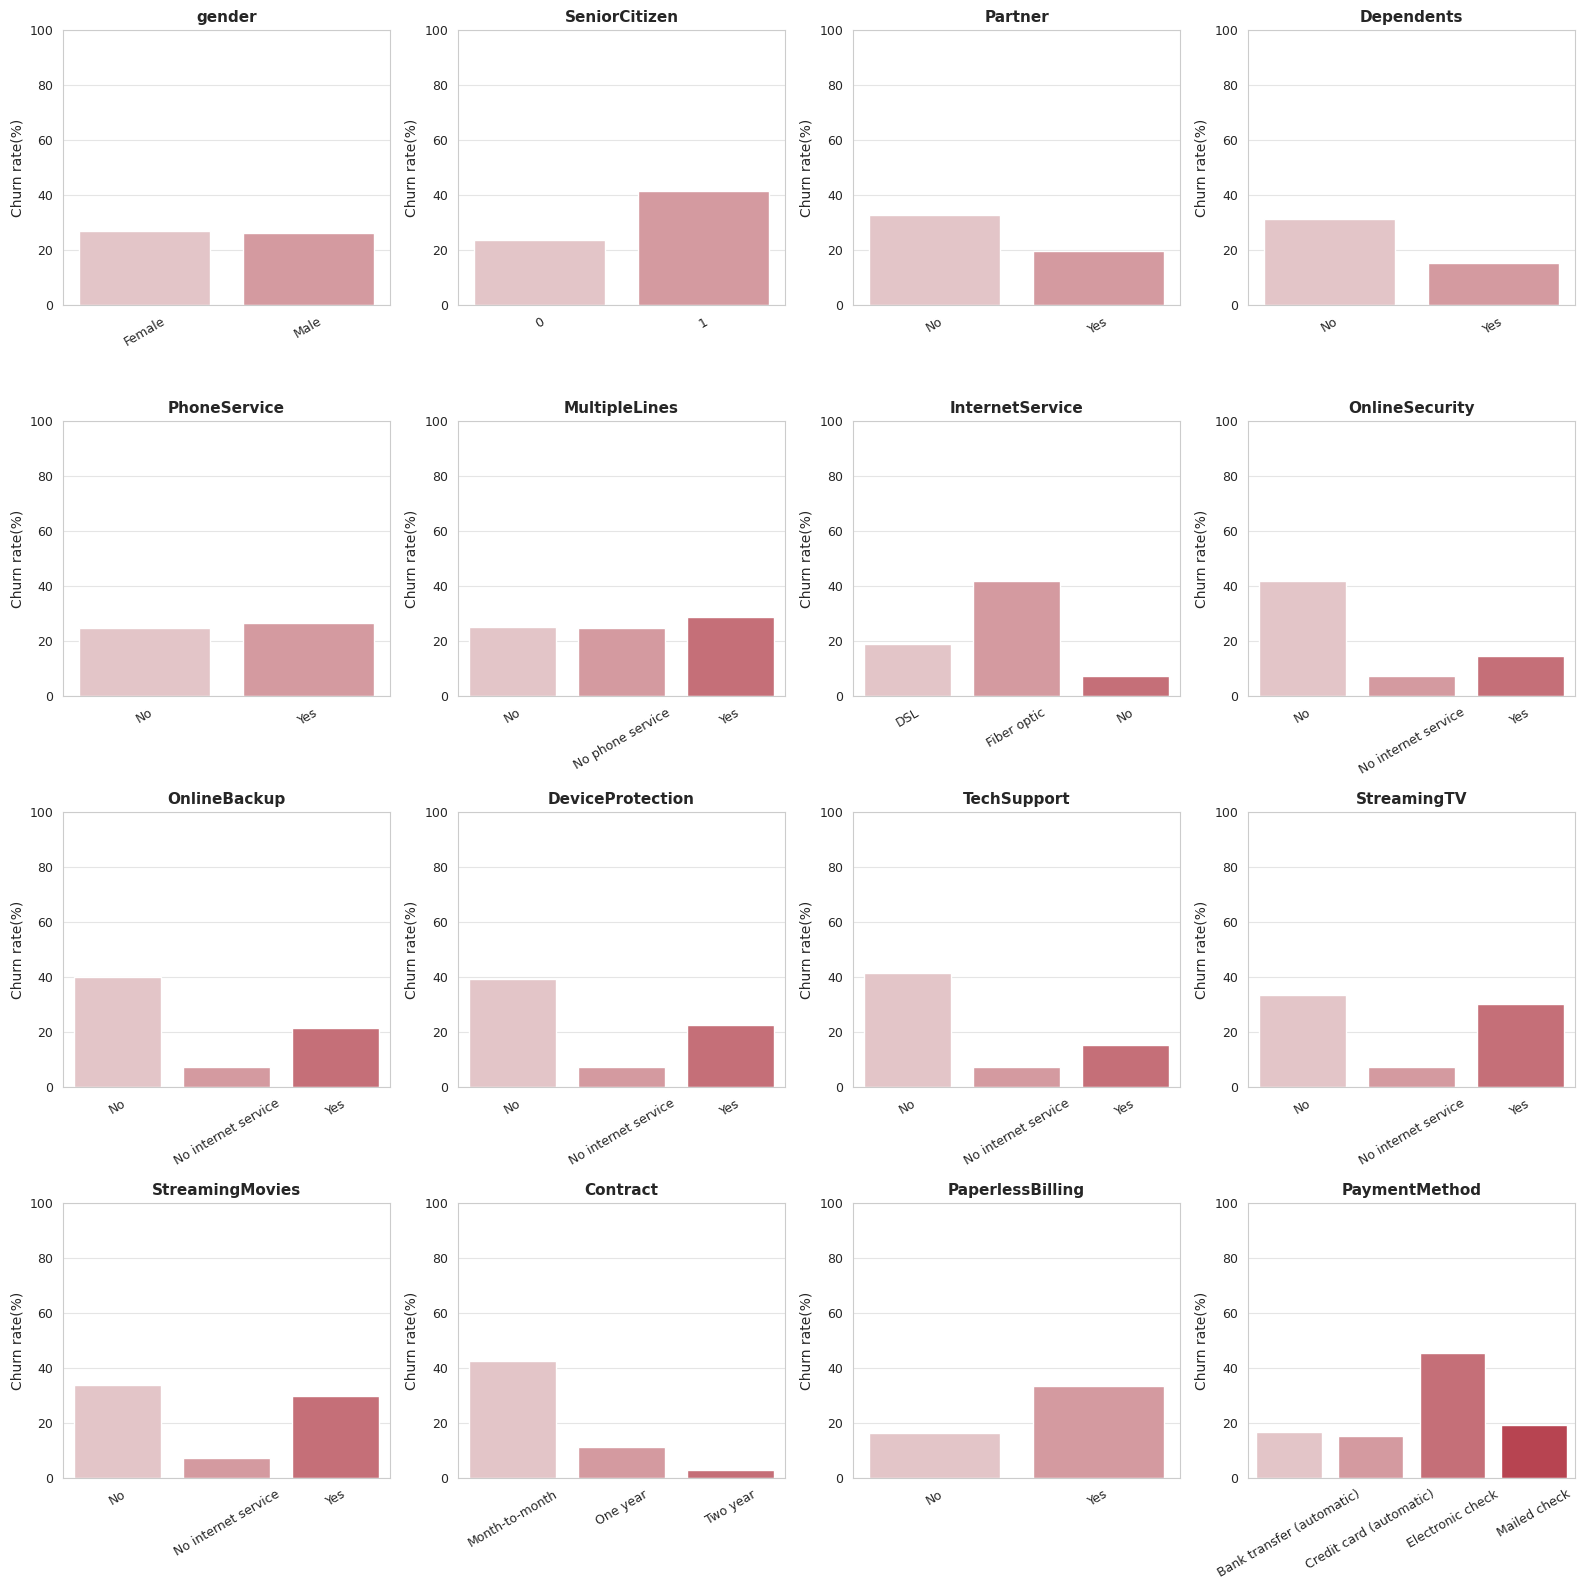

In [ ]:
demographic_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

categorical_cols = demographic_cols + service_cols + ['Contract', 'PaperlessBilling', 'PaymentMethod']

sns.set_style("whitegrid")
plt.rcParams.update({
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})

base_palette = sns.light_palette("#ca3142", n_colors=5, reverse=False)
base_palette = base_palette[1:]

fig_cat, axes_cat = plt.subplots(4, 4, figsize=(16, 16))
axes_flat = axes_cat.flatten()

for i, feature in enumerate(categorical_cols):
    ax = axes_flat[i]
    churn_rate = pd.crosstab(df[feature], df['Churn'], normalize='index') * 100
    classes = churn_rate.index.tolist()

    if len(classes) == 1:
        sns.barplot(x=churn_rate.index, y=churn_rate['Yes'], ax=ax, color=base_palette[1])
    else:
        palette = base_palette[:len(classes)]
        sns.barplot(x=churn_rate.index, y=churn_rate['Yes'], hue=churn_rate.index, ax=ax, palette=palette)

    ax.set_title(feature, fontsize=11, fontweight='semibold')
    ax.set_ylabel('Churn rate(%)')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)
    ax.set_ylim(0, 100)
    ax.yaxis.grid(True, alpha=0.5)
    ax.xaxis.grid(False)

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(len(categorical_cols), len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.savefig('tasa_churn.pdf')
plt.show()


Con este breve análisis podemos ver la tasa de abandono según los valores de cada una de nuestras variables.
- El género de nuestros clientes, si tienen o no servicio telefónico, o si tienen contratado con nostros multiples lineas telefónicas no influye en gran medida en la tasa de abandono.
- Según SeniorCitizen, Partner y Dependent, podemos ver que, en proporción, nos abandonan más personas jubiladas, sin pareja y sin personas dependientes en el contrato.
- Respecto al servicio de internet, los clientes que tienen contratado fibra óptica son los que más nos abandonan (con gran diferencia).
- Online Security, Online Backup, Device Protection y Tech Support nos indican que la mayor proporción de abandonos la tenemos por parte de clientes sin estos servicios contratados, lo que puede ser indicador de la satisfacción de los clientes que contratan nuestros servicios adicionales. Esto no ocurre con el servicio de Streaming TV o Movies, donde tenemos un porcentaje de abandonos similar para ambos tipos de clientes.
- Respecto al contrato y método de pago, el grueso de los clientes que nos abandonan parecen ser clientes con contrato mensual que pagan de forma electrónica.


A continuación, visualizamos las variables numéricas, junto a su distribución de valores.

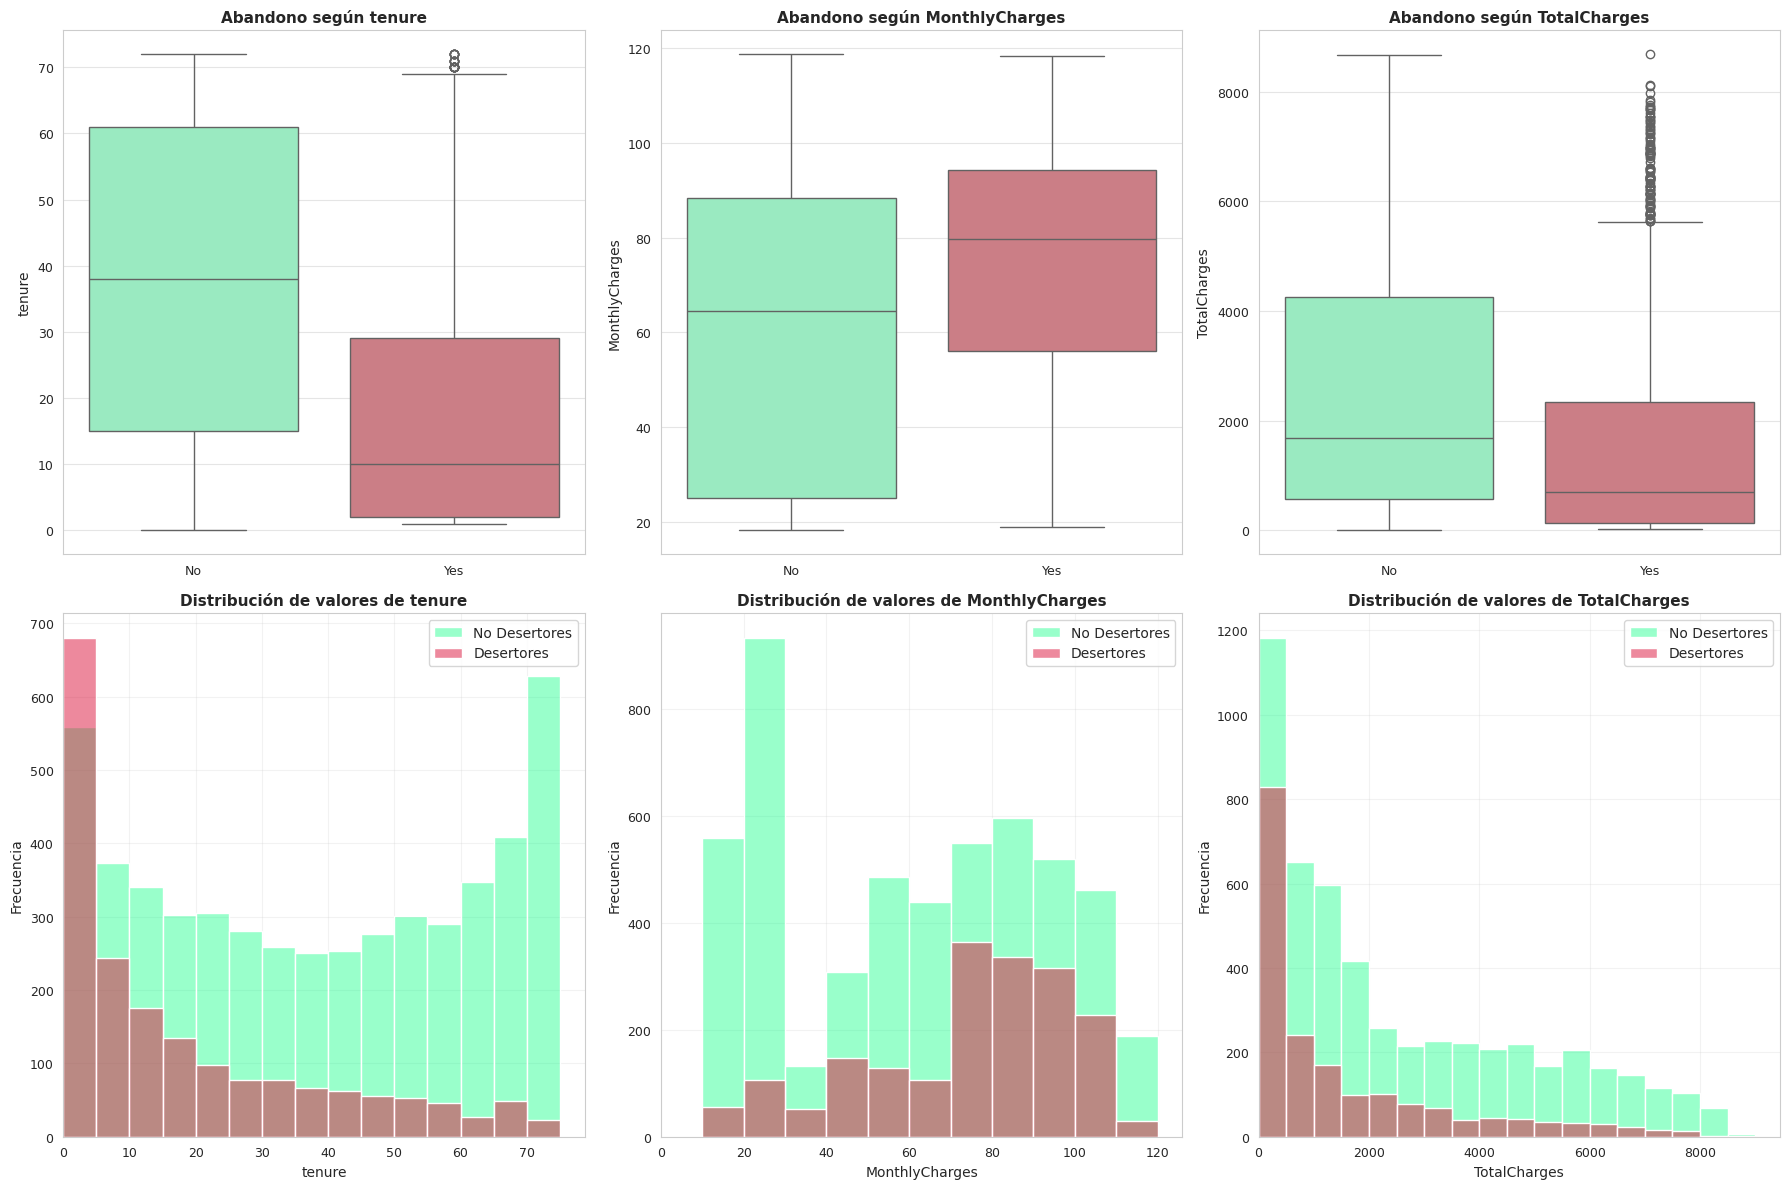

In [ ]:
bin_widths = {'tenure': 5, 'MonthlyCharges': 10, 'TotalCharges': 500}
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

paleta_verde = sns.light_palette("springgreen", n_colors=6, reverse=False)
paleta_roja = sns.light_palette("#ca3142", n_colors=10, reverse=False)

palette = {'Yes': paleta_roja[6], 'No': paleta_verde[2]}

fig_num, axes_num = plt.subplots(2, 3, figsize=(18, 12))

for i, feature in enumerate(numerical_cols):
    ax_box = axes_num[0, i]
    ax_hist = axes_num[1, i]

    sns.boxplot(x='Churn', y=feature, data=df, ax=ax_box, hue='Churn', palette=palette)
    ax_box.set_title(f'Abandono según {feature}', fontsize=11, fontweight='semibold')
    ax_box.set_xlabel('')
    ax_box.set_ylabel(feature)

    bins = range(0, int(df[feature].max()) + bin_widths[feature], bin_widths[feature])
    sns.histplot(df[df['Churn'] == 'No'][feature], color='springgreen', alpha=0.4,
                 label='No Desertores', ax=ax_hist, bins=bins)
    sns.histplot(df[df['Churn'] == 'Yes'][feature], alpha=0.5,
                 label='Desertores', ax=ax_hist, bins=bins, color='crimson')

    ax_hist.legend()
    ax_hist.set_title(f'Distribución de valores de {feature}', fontsize=11, fontweight='semibold')
    ax_hist.set_xlim(left=0)
    ax_hist.set_xlabel(feature)
    ax_hist.set_ylabel('Frecuencia')
    ax_box.yaxis.grid(True, alpha=0.5)
    ax_box.xaxis.grid(False)
    ax_hist.grid(True, alpha=0.25)

plt.tight_layout()
plt.savefig('tasa_churn_num.pdf')
plt.show()

- Analizando la distribución de los desertores y no desertores en función de los meses de permanencia, vemos que cuánto más tiempo pasan con nosotros, mayor permanencia. La gran mayoría de los clientes que nos abandonan lo hacen antes de cumplir el primer año con nosotros.
- Respecto a los cargos, no parece haber una diferencia significativa que nos haga discernir características de desertores y no desertores.

### Selección de características

Haremos una selección de características usando métodos de aprendizaje supervisado con el fin de determinar el perfil de posibles (y no posibles) desertores.

Lo primero, es darle el formato adecuado al dataframe para que puedan usarlo modelos de supervisados. Para ello:
1. Eliminamos los nulos.
2. Codificamos la deserción `Churn` como `Yes`$\rightarrow$1, `No`$\rightarrow$`0`.
3. Codificamos las variables categóricas.
4. Eliminamos la columna `customerID`.

In [ ]:
def pretty_data(df):
    data = df.copy()
    data_clean = data.dropna()

    if len(data_clean) < len(data):
        print(f"Eliminamos {len(data) - len(data_clean)} filas con valores nulos")

    data_clean['Churn_Encoded'] = data_clean['Churn'].map({'Yes': 1, 'No': 0})

    le = LabelEncoder()
    categorical_cols = []

    for col in data_clean.columns:
        if data_clean[col].dtype == 'object' and col != 'customerID':
            data_clean[col] = le.fit_transform(data_clean[col])
            categorical_cols.append(col)

    if 'customerID' in data_clean.columns:
        data_clean = data_clean.drop('customerID', axis=1)

    return data_clean, categorical_cols

Aplicamos la función para adecuar el formato de los datos a modelos de machine learning. Como predictores usamos en principio todas las características, quitando las columnas de deserción y deserción en forma categórica.

Dividimos el conjunto total de datos en conjuntos de *train* y *test* estratificados y los estandarizamos con un StandardScaler, es decir, llevamos las distribuciones de las variables a unas con media 0 y desviación estándar unitaria.

In [ ]:
processed_data, categorical_cols = pretty_data(df)

X = processed_data.drop(['Churn', 'Churn_Encoded'], axis=1)
y = processed_data['Churn_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dimensiones de X_train: (5282, 19)
Dimensiones de X_test: (1761, 19)


Usaremos varios modelos con una interpretabilidad relativamente alta para obtener resultados robustos. Definimos así los modelos:
- Regresión logística con penalización ElasticNet ($L1 + L2$): nos da un equilibrio entre selección de variables ($L1$) y estabilidad al manejar la multicolinealidad ($L2$).
- SVC con kernel lineal: lo introducimos como modelo robusto ante *outliers*.
- XGBoost: el modelo menos interpretable de los considerados, pero nos puede ayudar a buscar relaciones no triviales.
- CatBoost: otro modelo de boosting, aunque más ligero que XGBoost y con un sesgo más reducido.
- MLPClassifier: red neuronal simple con dos capas ocultas y regularización para no caer en overfitting. A pesar de no ser tan interpretable, nos ayuda a detectar patrones no lineales más sutiles.

In [ ]:
models = {'ElasticNetLR': make_pipeline(StandardScaler(),
                                        LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,
                                                           C=10.0, max_iter=20000, random_state=42)
                                        ),
          'LinearSVC': make_pipeline(StandardScaler(),
                                     LinearSVC(C=1.0, max_iter=10000, dual=False, random_state=42)
                                     ),
          'MLP': make_pipeline(StandardScaler(),
                               MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
                                             alpha=1e-4, learning_rate_init=1e-3, max_iter=500, early_stopping=True, random_state=42)
                               ),
          'XGBoost': XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.05, tree_method='hist', random_state=42, n_jobs=-1),
          'CatBoost': CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, task_type='CPU', random_state=42, verbose=False)
}


Ahora, entrenamos estos modelos con el conjunto de *train* y nos basamos en las predicciones sobre el conjunto de *test* para

In [ ]:
def compute_shap_feature_importance(models, X_train, X_test, y_train, y_test, feature_names=None):

  if feature_names is None and hasattr(X_train, "columns"):
      feature_names = X_train.columns

  imps, aucs = {}, {}
  total = len(models)
  print(f"Empezamos SHAP para {total} modelos.\n")

  for i, (name, mod) in enumerate(models.items(), 1):
    print(f"[{i}/{total}] Modelo: '{name}'")
    print(f"[{i}/{total}] Empezando el entrenamiento")
    mod.fit(X_train, y_train)
    print(f"[{i}/{total}] Terminamos el entrenamiento")

    # shap explainer
    if isinstance(mod, Pipeline): # modelos sin arboles
        if hasattr(mod, "predict_proba"):
            model_fun = lambda x: mod.predict_proba(x)
            output_names = ["neg", "pos"]

        else:
            model_fun = lambda x: mod.decision_function(x)
            output_names = None

        explainer = shap.Explainer(model_fun, masker=shap.maskers.Independent(X_train),
                                   feature_names=feature_names, output_names=output_names)

    else: # modelos de arboles
        explainer = shap.Explainer(mod, masker=shap.maskers.Independent(X_train), feature_names=feature_names)

    print(f"[{i}/{total}] Explainer creado, calculando los valores SHAP")
    shap_vals = explainer(X_test).values

    if shap_vals.ndim == 3:
        shap_vals = shap_vals[:, :, 1]

    imps[name] = np.abs(shap_vals).mean(axis=0)

    print(f"[{i}/{total}] Terminamos con el modelo: '{name}'\n\n")

  imp_df = pd.DataFrame(imps, index=feature_names)
  ranks = imp_df.rank(ascending=False)
  imp_df["median_rank"] = ranks.median(axis=1)
  imp_df.sort_values("median_rank", inplace=True)

  # graficamos el top-10
  top10 = imp_df.head(10).index
  temp = imp_df.loc[top10, models.keys()]
  norm = temp / temp.max()
  plot_df = norm.reset_index().melt("index", var_name="model", value_name="importancia")

  colorcitos = ['#00f7ff', '#8700FF', '#FF86F6', '#EA00D9', '#8A0000'] # colores lindos

  plt.figure(figsize=(10, 6))

  sns.barplot(data=plot_df, x="importancia", y="index", hue="model", palette=colorcitos)

  plt.title("Top-10 importancias SHAP (normalizadas)")
  plt.xlabel("Importancia normalizada")
  plt.ylabel("Característica")
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
  plt.tight_layout()
  plt.savefig('top10_shap.pdf')
  plt.show()

  return imp_df, aucs


Con la función anterior consideramos la importancia de las características en cada modelo (así como un parámetro global que explicaremos posteriormente).

Para medir la importancia de las características en cada modelo, usaremos los valores Shapley como una contribución equitativa. Estos valores dependen del promedio sobre todas las permutaciones posibles en que las características pueden entrar en el modelo, y puede ser tanto positiva como negativa, dependiendo de si aumenta o disminuye la probabilidad de predecir la clase positiva. Así, cuanto más positivo sea, más favorece la predicción de la clase positiva y, cuanto más negativo, más favorece la predicción de la clase negativa. Por tanto, resulta una medida más fiel a la contribución real de la variable.

A nivel técnico, esto lo conseguimos usando SHAP Explainer para la SVC, la regresión logística con elastic net y la red, y con el TreeExplainer que tienen los modelos de boosting. A partir de las matrices de valores SHAP generadas, tomando la media de cada columna podemos obtener la importancia de cada característica; esta media la hacemos con los valores en valor absoluto.



Empezamos SHAP para 5 modelos.

[1/5] Modelo: 'ElasticNetLR'
[1/5] Empezando el entrenamiento
[1/5] Terminamos el entrenamiento
[1/5] Explainer creado, calculando los valores SHAP


PermutationExplainer explainer: 1762it [00:51, 34.04it/s]                          


[1/5] Terminamos con el modelo: 'ElasticNetLR'


[2/5] Modelo: 'LinearSVC'
[2/5] Empezando el entrenamiento
[2/5] Terminamos el entrenamiento
[2/5] Explainer creado, calculando los valores SHAP


PermutationExplainer explainer: 1762it [00:34, 36.42it/s]                          


[2/5] Terminamos con el modelo: 'LinearSVC'


[3/5] Modelo: 'MLP'
[3/5] Empezando el entrenamiento
[3/5] Terminamos el entrenamiento
[3/5] Explainer creado, calculando los valores SHAP


PermutationExplainer explainer: 1762it [01:29, 17.47it/s]                          


[3/5] Terminamos con el modelo: 'MLP'


[4/5] Modelo: 'XGBoost'
[4/5] Empezando el entrenamiento
[4/5] Terminamos el entrenamiento
[4/5] Explainer creado, calculando los valores SHAP


 99%|===================| 1743/1761 [00:38<00:00]       

[4/5] Terminamos con el modelo: 'XGBoost'


[5/5] Modelo: 'CatBoost'
[5/5] Empezando el entrenamiento
[5/5] Terminamos el entrenamiento
[5/5] Explainer creado, calculando los valores SHAP


100%|===================| 1760/1761 [01:04<00:00]       

[5/5] Terminamos con el modelo: 'CatBoost'




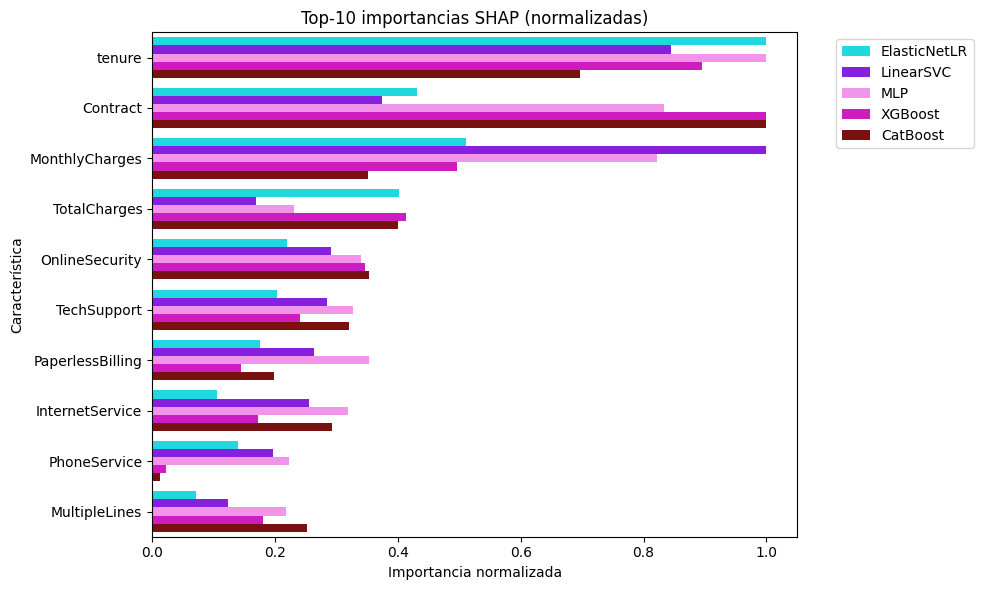

In [ ]:
imp_df, aucs = compute_shap_feature_importance(models, X_train_scaled, X_test_scaled, y_train, y_test, feature_names=X_train.columns)

Ahora, para deducir la importancia de las características y poder hacer un perfil tanto de desertores como de no desertores, definimos la importancia global como combinación de los resultados en los 5 modelos considerados. Para ello, hacemos un ranking a partir de las importancias SHAP vistas antes, donde asignamos 1 a la caracteristica más importante y seguimos en orden descendente hasta la más irrelevante.

Tras esto, nuestra medida global vendrá dada por la mediana de estos rangos, escogiéndola por encima de la media al ser más robusta ante *outliers*. De este modo, tenemos un ranking de características robusto antes discrepancias de modelos individuales y conociendo el motivo de las decisiones, lo cual resulta muy importante en este caso de negocio concreto.

In [ ]:
top10 = imp_df[['median_rank']].reset_index().rename(columns={'index': 'feature'})
top10 = top10.sort_values('median_rank').head(10)
top10

,feature,median_rank
0,tenure,2.0
1,Contract,2.0
2,MonthlyCharges,3.0
3,TotalCharges,4.0
4,OnlineSecurity,5.0
5,TechSupport,6.0
6,PaperlessBilling,7.0
7,InternetService,7.0
8,PhoneService,9.0
9,MultipleLines,10.0


Tras este análisis, tenemos claro que la permanencia y el tipo de contrato son las características con más influencia en el abandono de nuestros clientes, seguido por los costes mensuales. Si atendemos a la mediana por rangos sobre las 10 características más significativas, vemos que es complicado fijar una cota para generar el perfil de un cliente. Como lo que más nos importa son los desertores, trazaremos para ellos un perfil con 6 características clave para detectarlos. En los no desertores, esta cota puede ser más laxa, pero por mantener un estándar, conservaremos el mismo número de características. De este modo, atenderemos a las siguientes características para esquematizar los perfiles de clientes:
- Permanencia (tenure)
- Tipo de contrato (Contract)
- Factura mensual (MonthlyCharges)
- Seguridad online (OnlineSecurity)
- Soporte técnico (TechSupport)
- Tipo de servicio de internet (InternetService)

No incluimos los gastos totales (TotalCharges) porque está altamente correlacionada con la factura mensual y la permanencia, por lo que no aporta un valor añadido que no pueda ser extraido a partir de las variables anteriores. Tampoco incluimos la factura en papel porque actualmente gran parte de los contratos tienen métodos de pago y facturas electrónicas, siendo las facturas en papel usadas solo en contratos de clientes que llevan con nosotros desde antes de la transformación digital o clientes nuevos pero de avanzada edad, que prefieren mantener la factura de la forma tradicional.

#### **Perfil de posible desertor**

- Permanencia (tenure): baja permanencia, en su gran mayoria menos de un año y, en casi un 90%, menor a 2 años.
- Tipo de contrato (Contract): en su gran mayoría son clientes con contratos mensuales (de mes a mes). En este sector la tasa de abandono se eleva hasta el 40%.
- Factura mensual (MonthlyCharges): generalmente, el grupo de clientes que nos abandono tiende a pagar más ($\sim$ 80\$/mes) que los clientes fieles ($\sim$ 60\$/mes). Además, la gran mayoría de los clientes desertores concentran sus contratos entre los 60 y los 100$/mes.
- Seguridad online (OnlineSecurity): la gran mayoría de los desertores NO contrata con nosotros la seguridad online. El porcentaje de clientes que nos abandona cumpliendo estas características se eleva más allá del 40%.
- Soporte técnico (TechSupport): la gran mayoría de los desertores NO contrata con nosotros el soporte técnico. El porcentaje de clientes que nos abandona cumpliendo estas características se eleva más allá del 40%.
- Tipo de servicio de internet (InternetService): la gran mayoría de los desertores tiene contratado fibra óptica. El porcentaje de clientes que nos abandona cumpliendo estas características se eleva más allá del 40%. Esto nos indica posibles problemas con la calidad o precio de nuestra fibra óptica. Otro motivo es que la competencia ofrezca fibra de mejor calidad o a precios más competitivos.


Por tanto, los clientes que nos abandonan son, en su gran mayoría, clientes nuevos con contrato mensual de precio superior a 80$/mes y que no contratan ningún tipo de servicio o soporte técnico con nosotros. La fibra óptica parece un problema a estudiar desde la compañia; sería necesario hacer un estudio de mercado y evaluar el servicio que estamos ofreciendo mediante un análisis DAFO.

#### **Perfil de posible NO desertor**

- Permanencia (tenure): alta permanencia, en su gran mayoria 36 meses. El grueso de clientes fieles se sitúan por encima de un año de permanenca y por debajo de 5 años.
- Tipo de contrato (Contract): en su gran mayoría son clientes con contratos anuales o bianuales. Es muy raro que clientes con uno de los contratos anteriores nos abandone.
- Factura mensual (MonthlyCharges): generalmente, el grupo de clientes que nos abandono tiende a pagar aproximadamente 60\$/mes. No obstante, los contratos de nuestros cleintes files abarcan un rango muy amplio, desde los más baratos de los que disponemos, sobre los 20\$/mes, hasta los de mejor oferta y con más servicios incluidos, en torno a los 90\$/mes.
- Seguridad online (OnlineSecurity): la gran mayoría de nuestros clientes más fieles no tienen contratado un servicio de internet, por lo que no les aplica la seguridad online. No obstante, de los clientes con servicio de internet contratado, entre los que sí disponen de servicio de seguridad online, solo nos abandona un poco más del 10%, lo que indica alta fidelidad también entre los clientes con seguridad online contratada.
- Soporte técnico (TechSupport): la gran mayoría de nuestros clientes más fieles no tienen contratado un servicio de internet, por lo que no les aplica el soporte técnico. No obstante, de los clientes con servicio de internet contratado, entre los que sí disponen de servicio de soporte técnico, solo nos abandona un poco más del 10%, lo que indica alta fidelidad también entre los clientes con soporte técnico contratado.
- Tipo de servicio de internet (InternetService): de nuevo, nuestros clientes más fieles se caracterizan por no tener servicio de internet contratado. No obstante, entre los que sí lo tienen contratado, los que tienen DSL tienen una tasa de permanencia mucho mayor, sobre el 80%, lo que nos indica buena satisfacción con este servicio.


Por tanto, los clientes que permanecen con nostros se caracterizan por contratos anuales (al menos) de un precio variable en torno a 60\$/mes y que, de forma general, no tienen servicio de internet contratado. De los que tienen servicio de internet contratado, la contratación de servicios y soporte técnico la asociamos con una mayor fidelidad. Además, el factor clave es la permanencia de estos clientes: los datos demuestran que cuanto más tiempo pasan con nosotros, menos probabilidad de abandono existe.

**2. Segmentación/creación de grupos entre los desertores y los no desertores. Agrupar los usuarios dentro de cada clase en función de sus atributos más
relevantes. Esta segmentación será clave para diseñar la campaña de incentivos**

Preparamos los datos

In [ ]:
top_features = imp_df.head(10).index.tolist()

df_cluster = df.copy()
df_cluster = pd.get_dummies(df_cluster[top_features])
df_cluster['Churn'] = df['Churn']

desertores = df_cluster[df_cluster['Churn'] == 'No'].drop('Churn', axis=1)
no_desertores = df_cluster[df_cluster['Churn'] == 'Yes'].drop('Churn', axis=1)

scaler = StandardScaler()
X_desertores = scaler.fit_transform(desertores)
X_no_desertores = scaler.fit_transform(no_desertores)

Usamos el método del codo para averiguar el número óptimo de clasters en ambos grupos de clientes

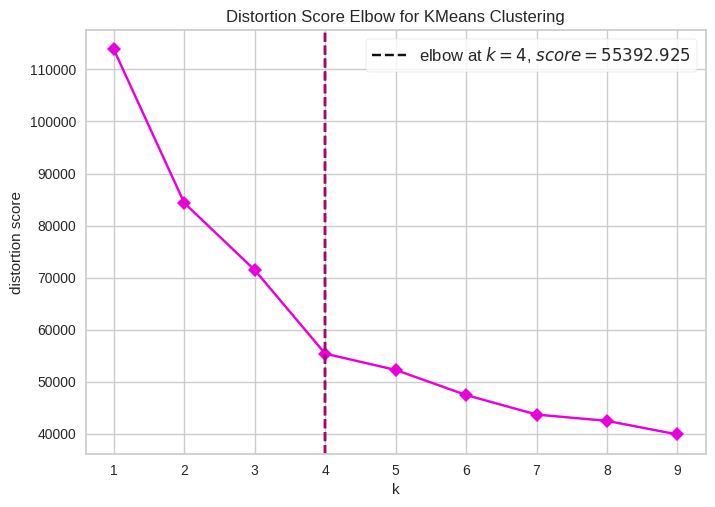

Número óptimo de clusters para Desertores: 4


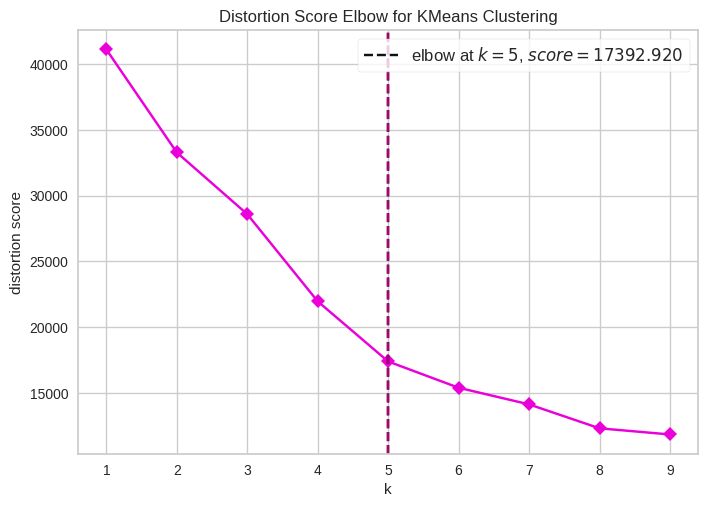

Número óptimo de clusters para No Desertores: 5


<Figure size 800x550 with 0 Axes>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow(X, title):
    model = KMeans(random_state=42)
    visualizer = KElbowVisualizer(model, k=(1, 10), timings=False)

    visualizer.fit(X)

    visualizer.ax.lines[0].set_color('#EA00D9')
    if visualizer.elbow_value_ is not None:
        elbow_idx = visualizer.k_values_.index(visualizer.elbow_value_)
        elbow_x = visualizer.k_values_[elbow_idx]
        elbow_y = visualizer.k_scores_[elbow_idx]
        visualizer.ax.axvline(x=elbow_x, linestyle='--', color='#B00070')


    visualizer.poof()
    print(f"Número óptimo de clusters para {title}: {visualizer.elbow_value_}")
    plt.savefig('elbow_method.pdf')

plot_elbow(X_desertores, 'Desertores')
plot_elbow(X_no_desertores, 'No Desertores')


In [ ]:
kmeans_desertores = KMeans(n_clusters=4, random_state=42)
desertores['Cluster'] = kmeans_desertores.fit_predict(X_desertores)

kmeans_no_desertores = KMeans(n_clusters=5, random_state=42)
no_desertores['Cluster'] = kmeans_no_desertores.fit_predict(X_no_desertores)


In [ ]:
pd.set_option('display.max_columns', None)

print("\n--- Desertores ---")
desertores.groupby('Cluster').mean()


--- Desertores ---


,tenure,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,PaperlessBilling_No,PaperlessBilling_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,22.187886,73.686434,1732.513195,0.874536,0.114957,0.010507,0.775649,0.0,0.224351,0.792336,0.0,0.207664,0.343016,0.656984,0.433869,0.566131,0.0,0.0,1.0,0.623609,0.0,0.376391
1,32.331210,21.136058,701.685740,0.300778,0.251238,0.447983,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.714084,0.285916,0.000000,0.000000,1.0,0.0,1.0,0.765039,0.0,0.234961
2,57.541386,89.278418,5208.500000,0.096260,0.389332,0.514408,0.321275,0.0,0.678725,0.302882,0.0,0.697118,0.365420,0.634580,0.458614,0.541386,0.0,0.0,1.0,0.276517,0.0,0.723483
3,37.017578,43.520996,1764.628906,0.435547,0.255859,0.308594,0.503906,0.0,0.496094,0.490234,0.0,0.509766,0.474609,0.525391,1.000000,0.000000,0.0,1.0,0.0,0.000000,1.0,0.000000


- El primer grupo que identificamos está formado por usuarios de alrededor de dos años de antigüedad que gastan unos 80€/mes. Contratan internet (tanto fibra como DSL) y teléfono, pero tienen contratos mensuales (mes a mes), sin añadir casi ningún tipo de servicio o soporte
- El segundo grupo lleva más de dos años con nosotros, pero sin internet contratado ni servicios extra. Tienen un consumo bajo, de unos 21 € al mes y muchos prefieren firmar con nosotros por uno o dos años.
- El tercer grupo que identificamos en los desertores van en contra de los anteriores: clientes veteranos (más de 5 años con nosotros), con facturas mensuales muy elevadas, por encima de 80€ y varios servicios y soporte contratados. Estos clientes nos interesa mantenerlos, ya que son de alto valor.
- El último grupo que identificamos aquí son clientes con solo DSL contratado y algún servicio contratado, pero facturas mensuales de unos 40€.

In [ ]:
print("\n--- No Desertores ---")
no_desertores.groupby('Cluster').mean()


--- No Desertores ---


,tenure,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,PaperlessBilling_No,PaperlessBilling_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,15.835294,37.533824,687.087941,0.900000,0.082353,0.017647,0.829412,0.0,0.170588,0.835294,0.0,0.164706,0.305882,0.694118,1.000000,0.000000,0.0,1.0,0.0,0.000000,1.0,0.000000
1,20.969871,89.119010,1950.335366,1.000000,0.000000,0.000000,0.879484,0.0,0.120516,0.883788,0.0,0.116212,0.126255,0.873745,0.045911,0.954089,0.0,0.0,1.0,0.001435,0.0,0.998565
2,50.810811,94.409189,4910.098108,0.021622,0.762162,0.216216,0.556757,0.0,0.443243,0.437838,0.0,0.562162,0.259459,0.740541,0.254054,0.745946,0.0,0.0,1.0,0.318919,0.0,0.681081
3,8.238938,20.368142,173.919912,0.876106,0.079646,0.044248,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.628319,0.371681,0.000000,0.000000,1.0,0.0,1.0,0.911504,0.0,0.088496
4,8.471591,72.254048,651.586790,0.997159,0.002841,0.000000,0.857955,0.0,0.142045,0.862216,0.0,0.137784,0.298295,0.701705,0.298295,0.701705,0.0,0.0,1.0,0.974432,0.0,0.025568


- El primer grupo de clientes fieles que encontramos son clientes que llevan con nostros unos 18 meses, pagando unos 38€/mes. Solo contratan servicio DSL de internet, pero ningún tipo de extra.
- El segundo grupo son clientes con un gasto mensual elevado, de unos 90€/mes con contratos mes a mes. La gran mayoria tienen contratada fibra óptica pero sin servicios adicionales contratados.
- El tercer grupo que identificamos son nuestros clientes más valiosos: clientes de factura elevada (sobre los 95€/mes) que llevan con nosostros un largo periodo de tiempo (más de cuatro años), con lo cual nos han dejado una facturación total elevada. Los contratos de estos clientes son, al menos, anuales, con una variedad de servicios adicionales contratados.
- Un cuarto grupo de clientes existente sería el opuesto al anterior: clientes nuevos (de menos de un año), con factura mensual extremadamente baja (20€/mes) y sin servicio de internet, por lo que tampoco disfrutan de nuestros servicios adicionales.
- Por último, identificamos un grupo que supone un compromiso entre el segundo y el cuarto: nuevos clientes (menos de un año) con contrato mes a mes y de facturación relativamente elevada (unos 72€/mes). Estos clientes recurren a nuestro servicio de internet por fibra óptica, pero no al soporte técnico o seguridad online que ofrecemos para complementarlo.